In [2]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import label_map_util
from utils import visualization_utils as vis_util
import random

%matplotlib inline
print("ok")

ok


In [3]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

#### Test on Udacity real track images

In [4]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH = r'models/ssd_udacity/frozen_inference_graph_nikola.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'data/udacity_label_map.pbtxt'
NUM_CLASSES = 13

In [5]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [7]:
IMAGE_SIZE = (12, 8)

#### Reference: https://github.com/coldKnight/TrafficLight_Detection-TensorFlowAPI/blob/master/TrafficLightDetection-Inference.ipynb

data/udacity_testarea_rgb\left0727.jpg
SCORES
[ 0.94945276  0.01271357  0.01137075  0.0068101   0.00405889  0.00343804
  0.00290401  0.00288001  0.00287385  0.00269479]
CLASSES
[ 1.  1.  3.  2.  2.  2.  2.  1.  3.  2.]


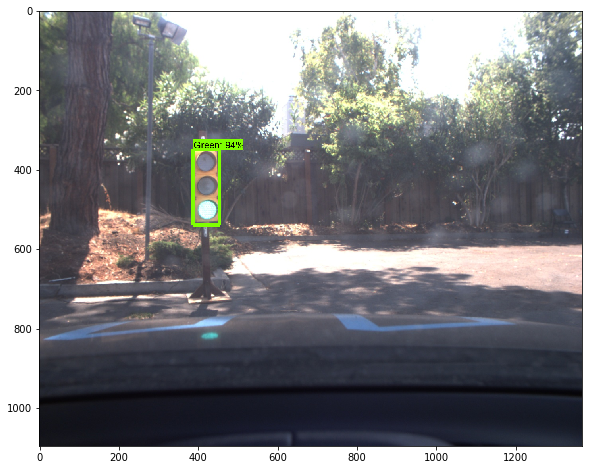

Green 0.949453
Distance (metres) 0.0
---------------------------------------------
data/udacity_testarea_rgb\left0726.jpg
SCORES
[ 0.96998179  0.00448196  0.00324241  0.00322786  0.00320812  0.00291145
  0.00275721  0.00227545  0.0022292   0.00207066]
CLASSES
[ 1.  1.  1.  2.  1.  1.  3.  4.  1.  4.]


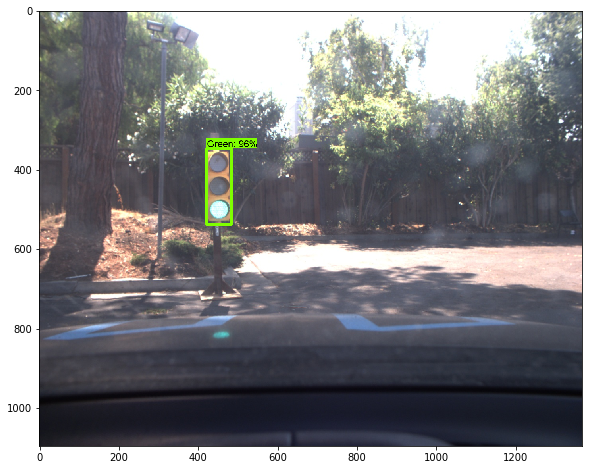

Green 0.969982
Distance (metres) 0.0
---------------------------------------------
data/udacity_testarea_rgb\left0723.jpg
SCORES
[ 0.97964281  0.00297427  0.00264277  0.00248275  0.00238925  0.0023845
  0.00234995  0.00227026  0.00225062  0.00224719]
CLASSES
[ 2.  4.  1.  1.  4.  4.  4.  4.  4.  2.]


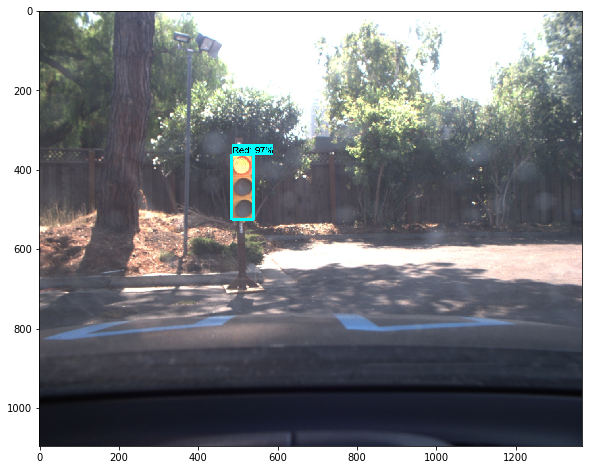

Red 0.979643
Distance (metres) 0.0
---------------------------------------------
data/udacity_testarea_rgb\left0721.jpg
SCORES
[ 0.99242181  0.00337745  0.00290548  0.00288526  0.00260698  0.00253698
  0.00231858  0.00222615  0.00222095  0.00217399]
CLASSES
[ 2.  4.  1.  2.  4.  3.  4.  3.  4.  2.]


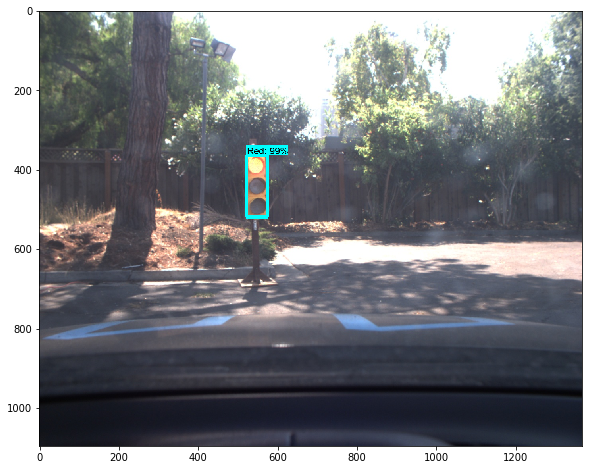

Red 0.992422
Distance (metres) 0.0
---------------------------------------------
data/udacity_testarea_rgb\left0722.jpg
SCORES
[ 0.97941381  0.00276961  0.00226213  0.00215613  0.00210846  0.0020267
  0.00196659  0.00193052  0.00192276  0.0019177 ]
CLASSES
[ 2.  4.  1.  1.  1.  2.  2.  4.  4.  4.]


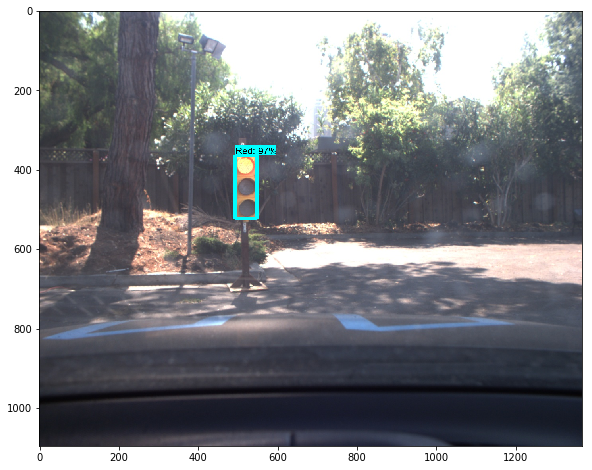

Red 0.979414
Distance (metres) 0.0
---------------------------------------------
data/udacity_testarea_rgb\left0725.jpg
SCORES
[ 0.97480011  0.00287856  0.00279774  0.00268695  0.00234777  0.00233676
  0.00224046  0.00206049  0.00205098  0.00202721]
CLASSES
[ 1.  1.  4.  4.  1.  3.  4.  1.  4.  1.]


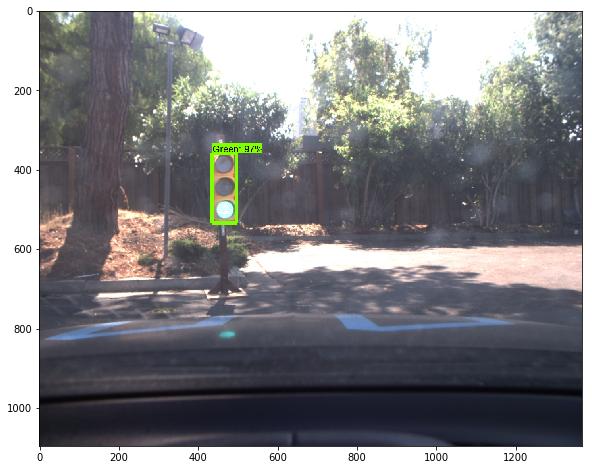

Green 0.9748
Distance (metres) 0.0
---------------------------------------------
data/udacity_testarea_rgb\left0724.jpg
SCORES
[ 0.45892072  0.00367646  0.0031128   0.00294738  0.00262521  0.00237251
  0.00236279  0.00233535  0.00225561  0.00210064]
CLASSES
[ 1.  2.  4.  1.  1.  2.  4.  4.  4.  1.]


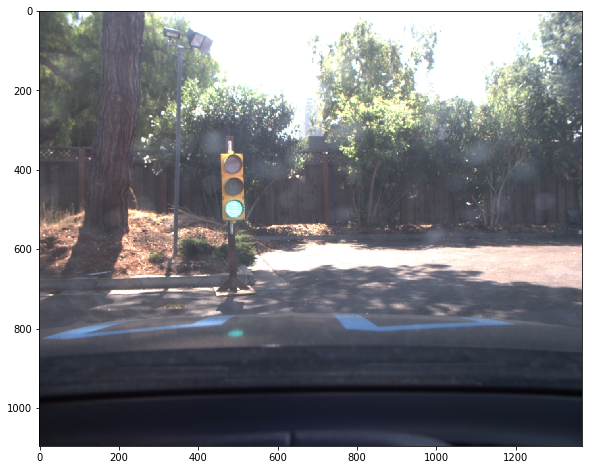

data/udacity_testarea_rgb\left0737.jpg
SCORES
[ 0.8142283   0.15534978  0.03176443  0.00444836  0.00369539  0.00346367
  0.00337975  0.00302884  0.00294138  0.00293716]
CLASSES
[ 1.  3.  2.  1.  1.  3.  3.  2.  1.  4.]


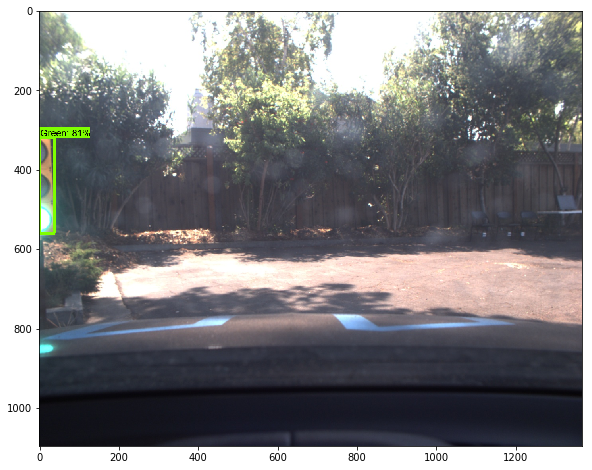

Green 0.814228
Distance (metres) 0.0
---------------------------------------------


In [11]:
PATH_TO_IMGS = r'data/udacity_testarea_rgb'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        #print(TEST_IMGS)
        for idx, img_path in enumerate(TEST_IMGS):
            print(img_path)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                boxes,
                classes,
                scores,
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            min_score_thresh = .50
            if scores is None or scores[0] > min_score_thresh:
                class_name = category_index[classes[0]]['name']
                print('{}'.format(class_name), scores[0])
                    
                fx =  0.97428
                fy =  1.73205
                perceived_width_x = (boxes[0][3] - boxes[0][1]) * 800
                perceived_width_y = (boxes[0][2] - boxes[0][0]) * 600

                # ymin, xmin, ymax, xmax = box
                # depth_prime = (width_real * focal) / perceived_width
                perceived_depth_x = ((.1 * fx) / perceived_width_x)
                perceived_depth_y = ((.3 * fy) / perceived_width_y )

                estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                print("Distance (metres)", estimated_distance)
                #print("Time in milliseconds", (time1 - time0) * 1000, "\n")
                print("---------------------------------------------")
            
            if idx == 20:#10
                break

#### Find IMUs

In [30]:
# To label images
PATH_TO_IMGS = r'data/udacity_testarea_rgb'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))

truth_dict={}

for img_path in TEST_IMGS:
    img_no = int(img_path.split('\\')[1][-8:-4])
    if img_no >= 672 and img_no <=723:
        truth_dict[img_path] = 2-1
    elif img_no >= 724 and img_no <=737:
        truth_dict[img_path] = 1-1
    elif img_no >= 890 and img_no <=904:
        truth_dict[img_path] = 2-1
    elif img_no >= 890 and img_no <=926:
        truth_dict[img_path] = 1-1
    elif img_no >= 1075 and img_no <=1126:
        truth_dict[img_path] = 1-1
    else:
        truth_dict[img_path] = 4-1
print(truth_dict)

{'data/udacity_testarea_rgb\\left0725.jpg': 0, 'data/udacity_testarea_rgb\\left0737.jpg': 0, 'data/udacity_testarea_rgb\\left0726.jpg': 0, 'data/udacity_testarea_rgb\\left0721.jpg': 1, 'data/udacity_testarea_rgb\\left0723.jpg': 1, 'data/udacity_testarea_rgb\\left0724.jpg': 0, 'data/udacity_testarea_rgb\\left0727.jpg': 0, 'data/udacity_testarea_rgb\\left0722.jpg': 1}


In [31]:
label_dict = {}
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        #print(TEST_IMGS)
        for idx, img_path in enumerate(TEST_IMGS):
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            #boxes = np.squeeze(boxes)
            score = np.squeeze(scores)[0]
            class_state = np.squeeze(classes).astype(np.int32)[0]
            
            
            min_score_thresh = .50
            
            if score > 0.2:
                label_dict[img_path] = class_state-1
            else:
                label_dict[img_path] = 4-1
print(label_dict)

{'data/udacity_testarea_rgb\\left0725.jpg': 0, 'data/udacity_testarea_rgb\\left0737.jpg': 0, 'data/udacity_testarea_rgb\\left0726.jpg': 0, 'data/udacity_testarea_rgb\\left0721.jpg': 1, 'data/udacity_testarea_rgb\\left0723.jpg': 1, 'data/udacity_testarea_rgb\\left0724.jpg': 0, 'data/udacity_testarea_rgb\\left0727.jpg': 0, 'data/udacity_testarea_rgb\\left0722.jpg': 1}


In [32]:
truth_array = []
predict_array = []
for img_path in TEST_IMGS:
    predict_array.append(label_dict[img_path])
    truth_array.append(truth_dict[img_path])
    print(img_path)
print(truth_array)
print(predict_array)

data/udacity_testarea_rgb\left0721.jpg
data/udacity_testarea_rgb\left0722.jpg
data/udacity_testarea_rgb\left0723.jpg
data/udacity_testarea_rgb\left0724.jpg
data/udacity_testarea_rgb\left0725.jpg
data/udacity_testarea_rgb\left0726.jpg
data/udacity_testarea_rgb\left0727.jpg
data/udacity_testarea_rgb\left0737.jpg
[1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0]


In [33]:
def mean_iou(ground_truth, prediction, num_classes):
    iou, iou_op = tf.metrics.mean_iou(labels=ground_truth,predictions=prediction,num_classes=num_classes)
    return iou, iou_op

ground_truth = tf.constant(truth_array)
prediction = tf.constant(predict_array)

iou, iou_op = mean_iou(ground_truth,prediction,2)

with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # need to initialize local variables for this to run `tf.metrics.mean_iou`
        sess.run(tf.local_variables_initializer())
        
        sess.run(iou_op)
        print("Mean IoU =", sess.run(iou))

Mean IoU = 1.0


#### Test on sim images

In [13]:
PATH_TO_GRAPH = r'models/ssd_sim/frozen_inference_graph.pb' ## load SSD trained on udacity's simulator images
detection_graph = load_graph(PATH_TO_GRAPH)

Green
Red
Yellow
Unknown
21
0
SCORES
[ 0.99975926  0.35111898  0.24030375  0.19302349  0.12376578  0.04789217
  0.0166542   0.01369788  0.01363101  0.00639456]
CLASSES
[ 1.  1.  2.  1.  2.  2.  1.  1.  3.  1.]


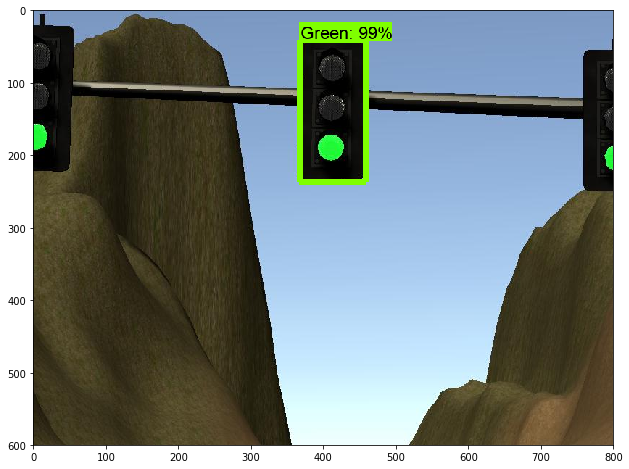

1
SCORES
[ 0.99970067  0.44401729  0.01954463  0.01252182  0.00936916  0.00698661
  0.00618571  0.00593094  0.00536484  0.00527744]
CLASSES
[ 2.  2.  2.  1.  1.  2.  2.  2.  3.  3.]


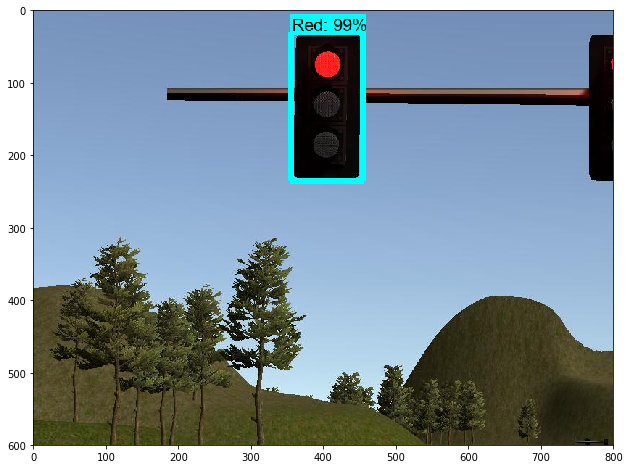

2
SCORES
[ 0.98176193  0.93579334  0.92219472  0.01446017  0.01036916  0.00910414
  0.00804061  0.00657452  0.00626513  0.00600124]
CLASSES
[ 3.  3.  3.  3.  3.  3.  2.  3.  3.  3.]


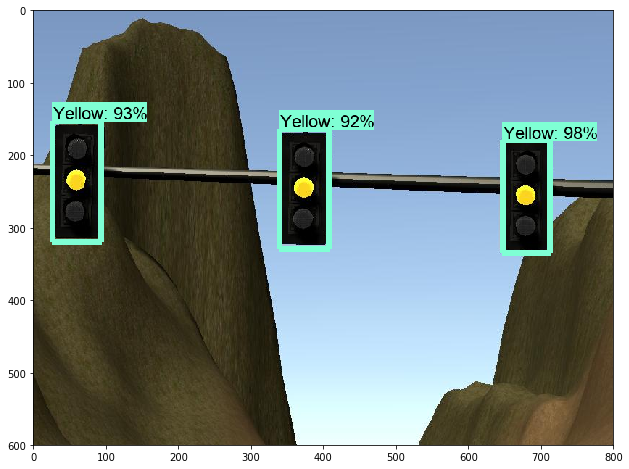

3
SCORES
[ 0.99929011  0.98403901  0.02384781  0.01233483  0.00817868  0.00640099
  0.00540419  0.00540127  0.00481461  0.0046009 ]
CLASSES
[ 3.  3.  3.  3.  3.  1.  3.  1.  1.  3.]


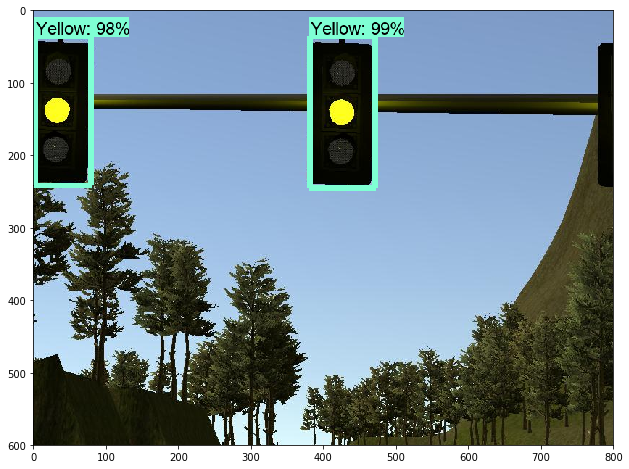

4
SCORES
[ 0.99969876  0.99964273  0.00547638  0.00541378  0.00511716  0.00510586
  0.00465698  0.00460313  0.00446768  0.00383839]
CLASSES
[ 1.  1.  1.  3.  4.  1.  3.  4.  1.  3.]


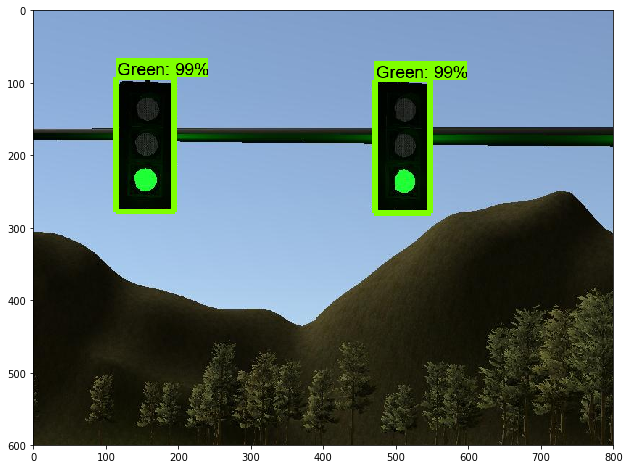

5
SCORES
[ 0.02474748  0.01829468  0.00890747  0.00650488  0.00645671  0.00632403
  0.00625366  0.00611661  0.00603835  0.00580552]
CLASSES
[ 2.  2.  3.  4.  2.  2.  1.  4.  4.  1.]


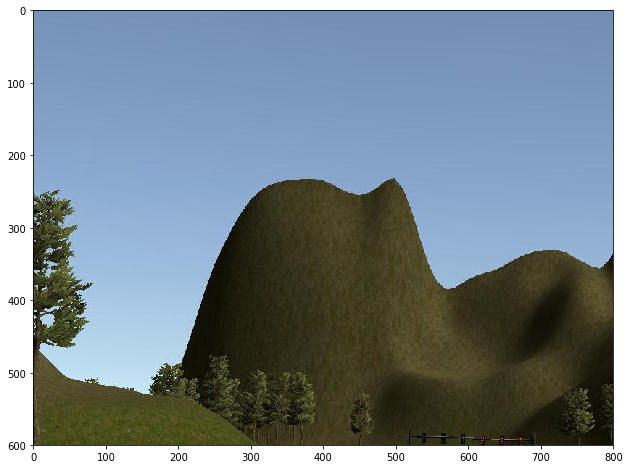

6
SCORES
[ 0.01335584  0.00835792  0.00835627  0.00824303  0.00567231  0.00544499
  0.00508319  0.00502751  0.00473209  0.00466095]
CLASSES
[ 2.  4.  4.  2.  4.  4.  1.  1.  4.  4.]


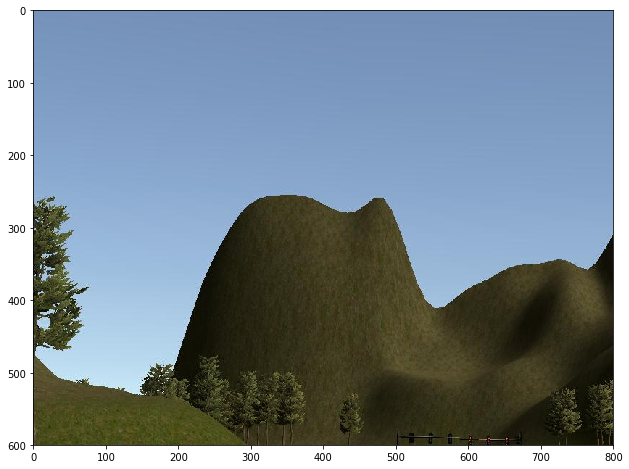

7
SCORES
[ 0.5923115   0.53149909  0.15404885  0.00872084  0.00768325  0.00709783
  0.00581241  0.00538306  0.00532487  0.0050338 ]
CLASSES
[ 3.  3.  3.  3.  3.  4.  4.  3.  3.  3.]


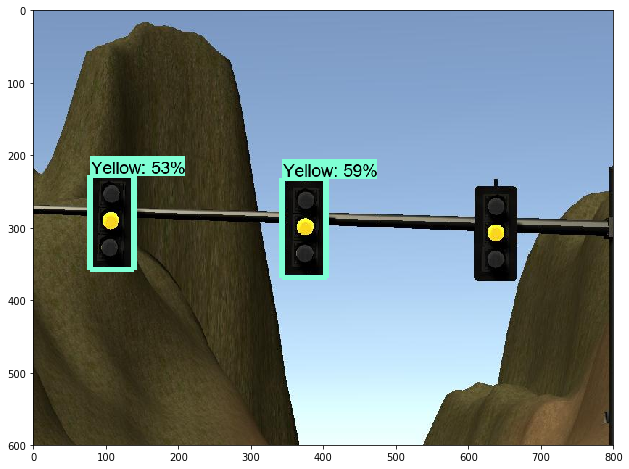

8
SCORES
[ 0.00720356  0.00661575  0.00612641  0.00601123  0.00577566  0.00498326
  0.00490218  0.00431772  0.00416982  0.00414932]
CLASSES
[ 1.  4.  2.  3.  1.  1.  2.  3.  4.  4.]


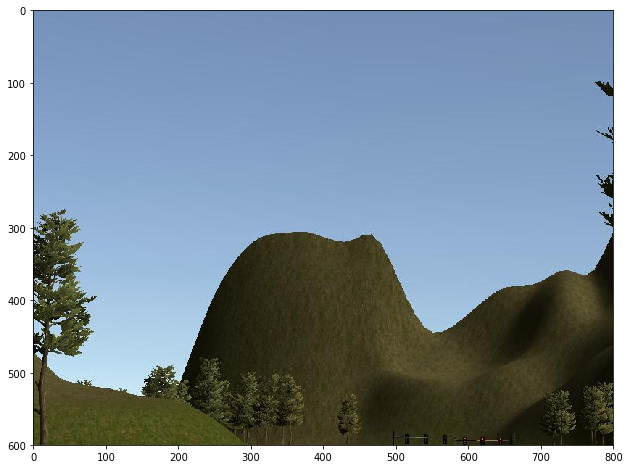

9
SCORES
[ 0.99865556  0.99803787  0.99240416  0.01141319  0.00955646  0.00564224
  0.00544441  0.00535421  0.00510379  0.00486616]
CLASSES
[ 1.  1.  1.  2.  2.  2.  1.  4.  4.  2.]


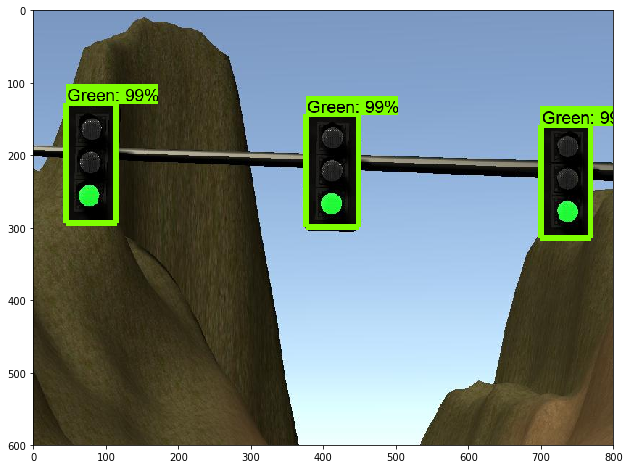

10
SCORES
[ 0.99567527  0.99567348  0.99214137  0.0095573   0.00732861  0.00724532
  0.00697094  0.00644092  0.00589904  0.00583646]
CLASSES
[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]


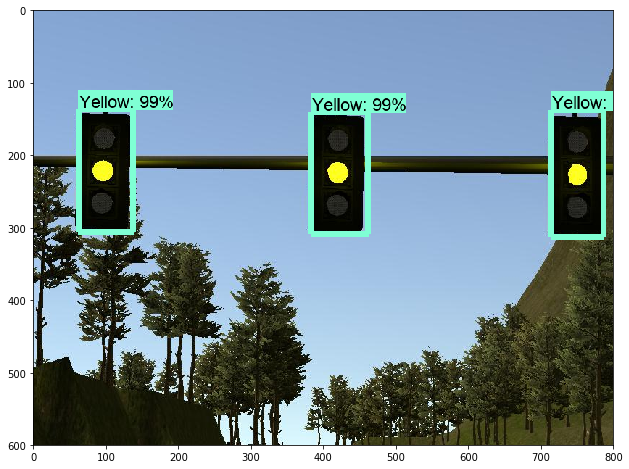

In [20]:
PATH_TO_IMGS = r'data/simulator_dataset_rgb'
subfolder = ['Green', 'Red', 'Yellow', 'Unknown']
TEST_IMGS = []
for i in subfolder:
    TEST_IMGS += glob(os.path.join(os.path.join(PATH_TO_IMGS, i), r'*.png'))
    print(i)
random.shuffle(TEST_IMGS)
print(len(TEST_IMGS))
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            print(idx)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break